# Imports

In [1]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from os import listdir
from os.path import join, isfile
#preprocessin
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#model and layers
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#metrics
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import tensorflow as tf

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
epochs = 30

In [4]:
files = listdir('/kaggle/input/plantvillage/PlantVillage/train/')
files = [f.lower() for f in files]   # Convert to lower case
sorted(files)

['apple___apple_scab',
 'apple___black_rot',
 'apple___cedar_apple_rust',
 'apple___healthy',
 'blueberry___healthy',
 'cherry_(including_sour)___healthy',
 'cherry_(including_sour)___powdery_mildew',
 'corn_(maize)___cercospora_leaf_spot gray_leaf_spot',
 'corn_(maize)___common_rust_',
 'corn_(maize)___healthy',
 'corn_(maize)___northern_leaf_blight',
 'grape___black_rot',
 'grape___esca_(black_measles)',
 'grape___healthy',
 'grape___leaf_blight_(isariopsis_leaf_spot)',
 'orange___haunglongbing_(citrus_greening)',
 'peach___bacterial_spot',
 'peach___healthy',
 'pepper,_bell___bacterial_spot',
 'pepper,_bell___healthy',
 'potato___early_blight',
 'potato___healthy',
 'potato___late_blight',
 'raspberry___healthy',
 'soybean___healthy',
 'squash___powdery_mildew',
 'strawberry___healthy',
 'strawberry___leaf_scorch',
 'tomato___bacterial_spot',
 'tomato___early_blight',
 'tomato___healthy',
 'tomato___late_blight',
 'tomato___leaf_mold',
 'tomato___septoria_leaf_spot',
 'tomato___spid

In [5]:
label =files
NUM_CLASS=len(label)

In [6]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

In [7]:
train_generator = train_gen.flow_from_directory(
    directory="/kaggle/input/plantvillage/PlantVillage/train/",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 43444 images belonging to 38 classes.


In [8]:
valid_generator = val_gen.flow_from_directory(
    directory='/kaggle/input/plantvillage/PlantVillage/val/',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

Found 10861 images belonging to 38 classes.


In [9]:
class_dict= {v:k for k,v in train_generator.class_indices.items()}
class_dict

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [10]:
def see_examples(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()

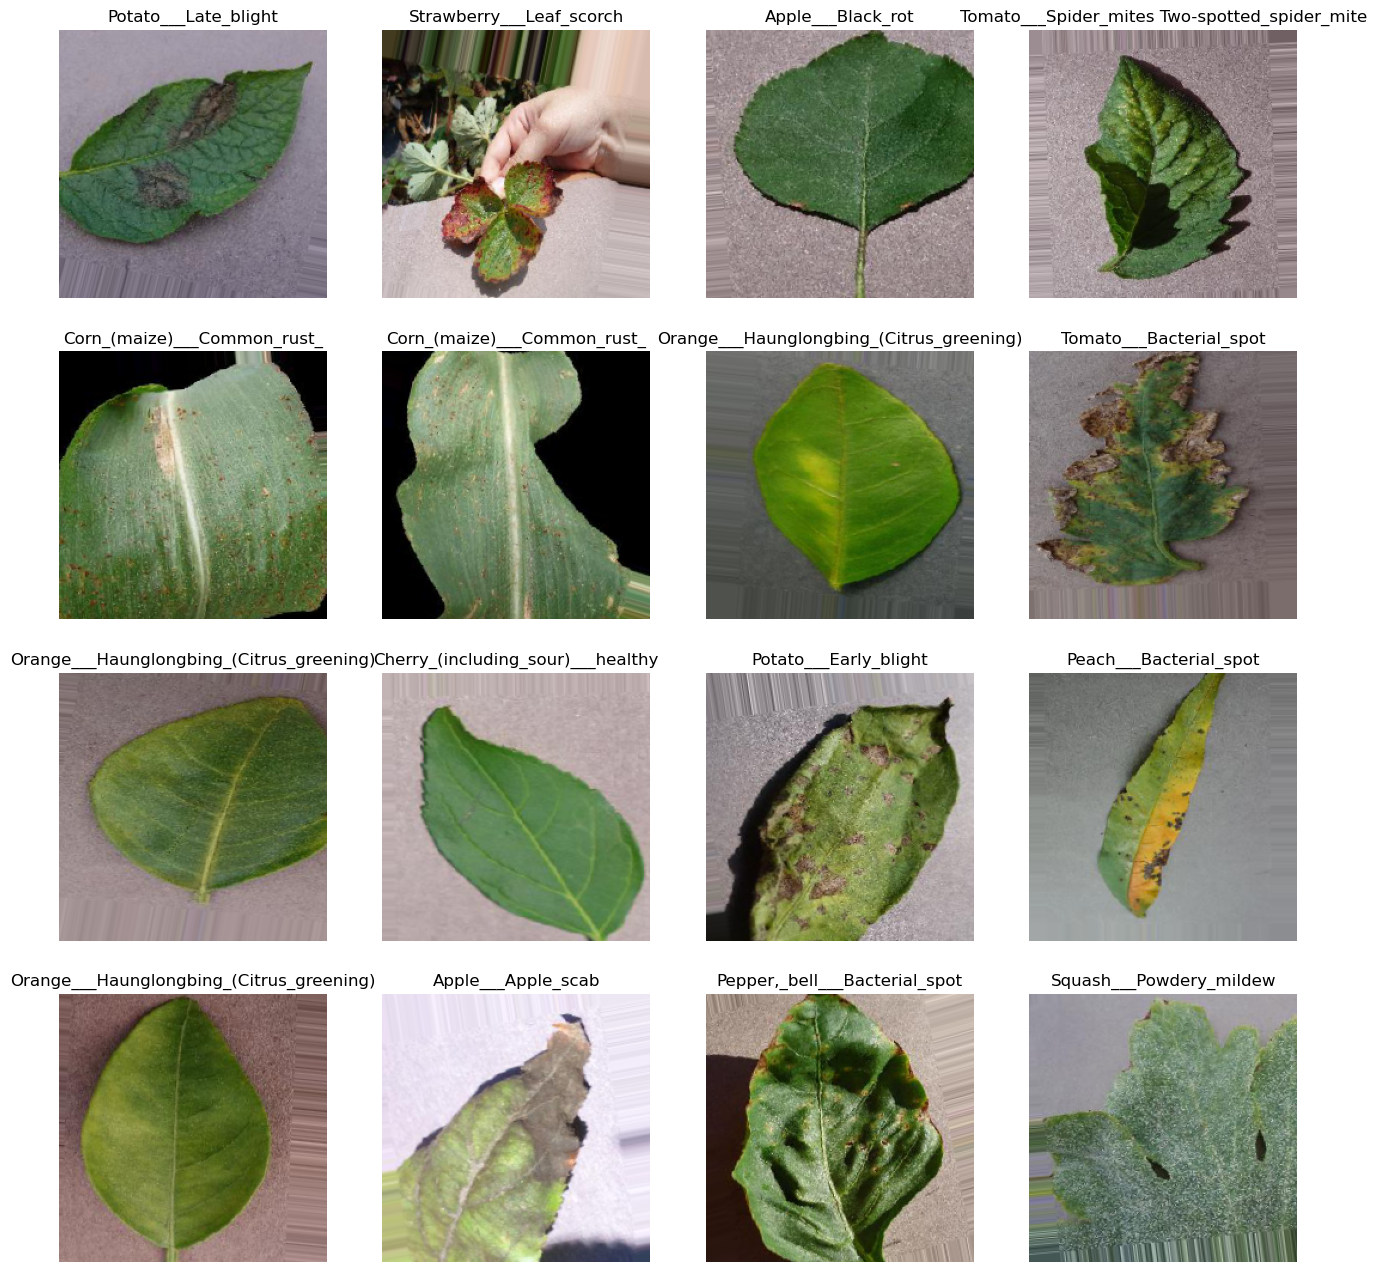

In [11]:
see_examples(train_generator)

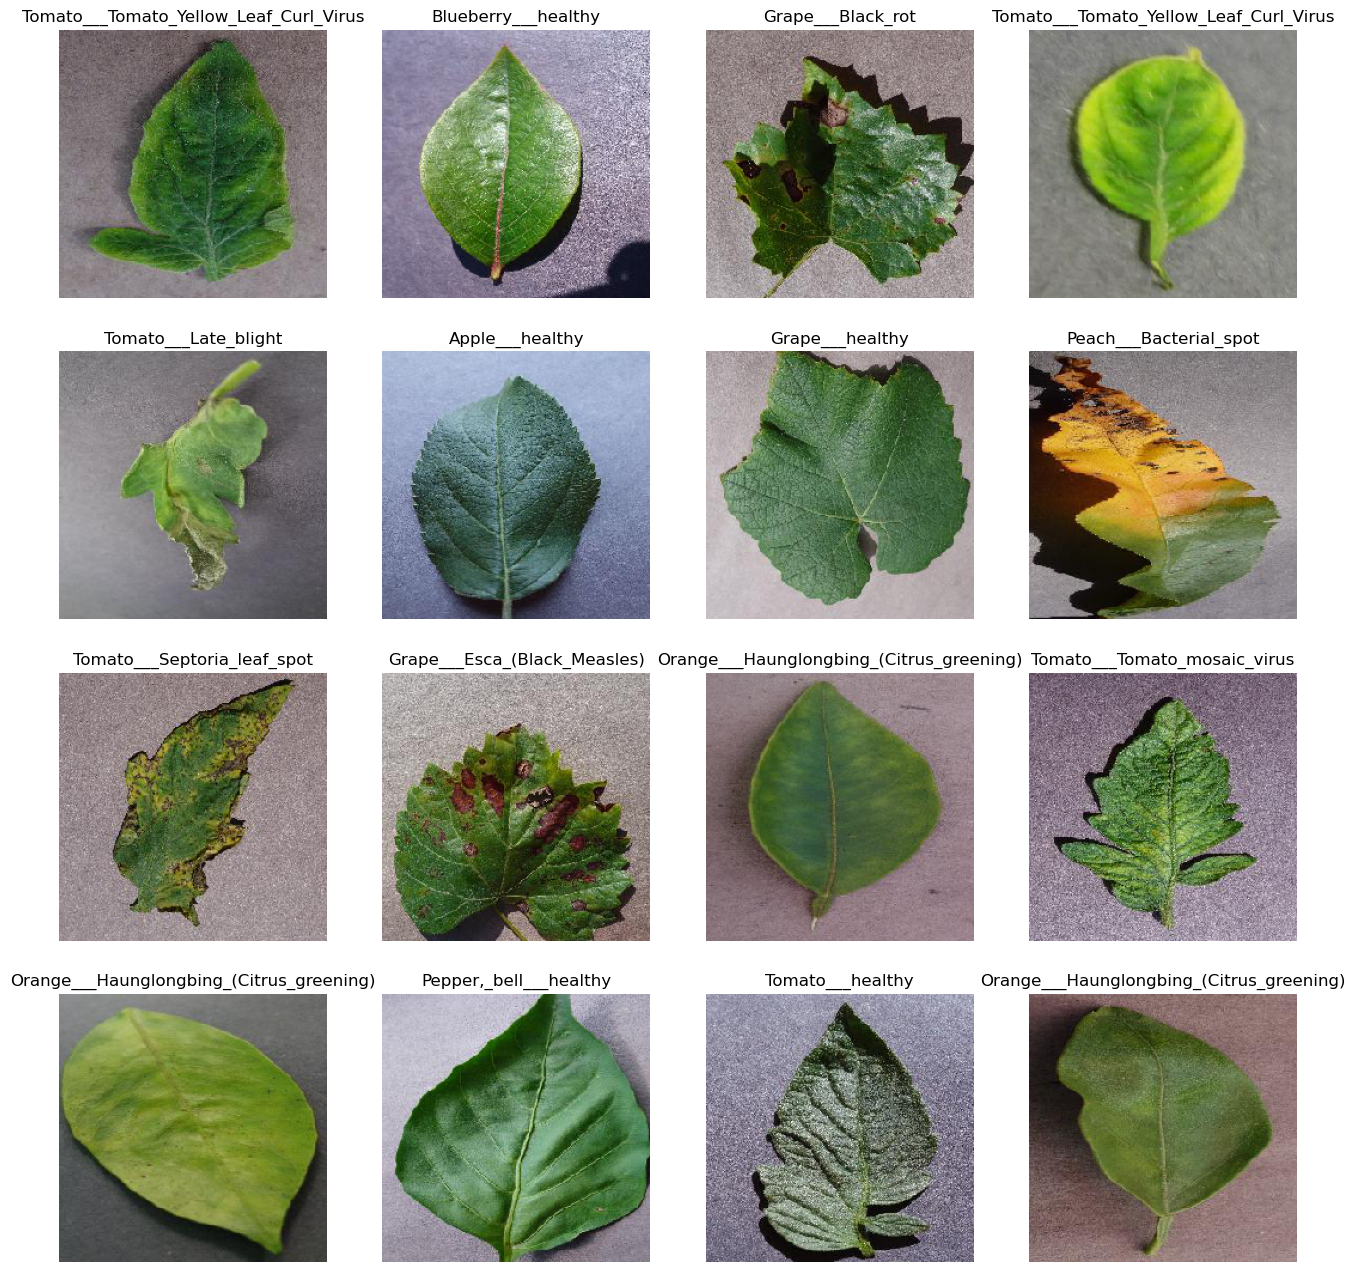

In [13]:
see_examples(valid_generator)

In [18]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))


16804768/16804768 [==============================] - 0s 0us/step


In [19]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False 

In [20]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    
    Dense(units=512,activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=NUM_CLASS, activation='softmax')
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [22]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=15),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.001)
]

metrics = [
    CategoricalAccuracy(), 
    F1Score(num_classes=NUM_CLASS), 
    Precision(), 
    Recall(), 
#     AUC()
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [23]:
history = model.fit(train_generator,epochs=epochs, batch_size=BATCH_SIZE,
                  validation_data=valid_generator,callbacks= callbacks,
                            metrics = metrics )

Epoch 1/30


2023-03-18 11:15:59.103252: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


679/679 [==============================] - 1013s 1s/step - loss: 0.4444 - categorical_accuracy: 0.8784 - f1_score: 0.8388 - precision: 0.9394 - recall: 0.8404 - val_loss: 0.1243 - val_categorical_accuracy: 0.9645 - val_f1_score: 0.9491 - val_precision: 0.9687 - val_recall: 0.9599 - lr: 0.0010
Epoch 2/30
679/679 [==============================] - 725s 1s/step - loss: 0.1446 - categorical_accuracy: 0.9607 - f1_score: 0.9458 - precision: 0.9689 - recall: 0.9531 - val_loss: 0.1406 - val_categorical_accuracy: 0.9647 - val_f1_score: 0.9454 - val_precision: 0.9684 - val_recall: 0.9629 - lr: 0.0010
Epoch 3/30
679/679 [==============================] - 707s 1s/step - loss: 0.1047 - categorical_accuracy: 0.9707 - f1_score: 0.9604 - precision: 0.9764 - recall: 0.9656 - val_loss: 0.0826 - val_categorical_accuracy: 0.9789 - val_f1_score: 0.9656 - val_precision: 0.9820 - val_recall: 0.9772 - lr: 0.0010
Epoch 4/30
679/679 [==============================] - 693s 1s/step - loss: 0.0825 - categorical_ac

In [24]:
history_df = pd.DataFrame(history.history)
history_df.head()

loss  categorical_accuracy  \
0  0.444422              0.878395   
1  0.144573              0.960685   
2  0.104661              0.970698   
3  0.082537              0.977488   
4  0.080124              0.977488   

                                            f1_score  precision    recall  \
0  [0.7790576, 0.8279569, 0.7786667, 0.89694655, ...   0.939430  0.840392   
1  [0.93849206, 0.95846003, 0.93394077, 0.9701097...   0.968879  0.953089   
2  [0.9622266, 0.9659319, 0.96330273, 0.9791113, ...   0.976422  0.965634   
3  [0.9582505, 0.9848638, 0.98173517, 0.9840546, ...   0.981003  0.973506   
4  [0.9561753, 0.9770688, 0.98173517, 0.97410506,...   0.981168  0.973828   

   val_loss  val_categorical_accuracy  \
0  0.124266                  0.964460   
1  0.140629                  0.964736   
2  0.082568                  0.978915   
3  0.111200                  0.970168   
4  0.117598                  0.972286   

                                        val_f1_score  val_precision  \
0  [0.88339216, 0.98039216, 0.972973, 0.9744361, ...       0.968686   
1  [0.9799197, 0.9157509, 0.88888896, 0.9908258, ...       0.968423   
2  [0.9541985, 0.9959839, 0.99099094, 0.9847561, ...       0.981958   
3  [1.0, 0.9920635, 0.9908257, 0.99236643, 0.9933...       0.972012   
4  [0.9842519, 1.0, 1.0, 0.9984825, 0.9917355, 0....       0.973427   

   val_recall     lr  
0    0.959856  0.001  
1    0.962895  0.001  
2    0.977166  0.001  
3    0.968879  0.001  
4    0.971365  0.001

In [25]:
history_df['f1_score'] = history_df['f1_score'].apply(np.mean)
history_df['val_f1_score'] = history_df['val_f1_score'].apply(np.mean)

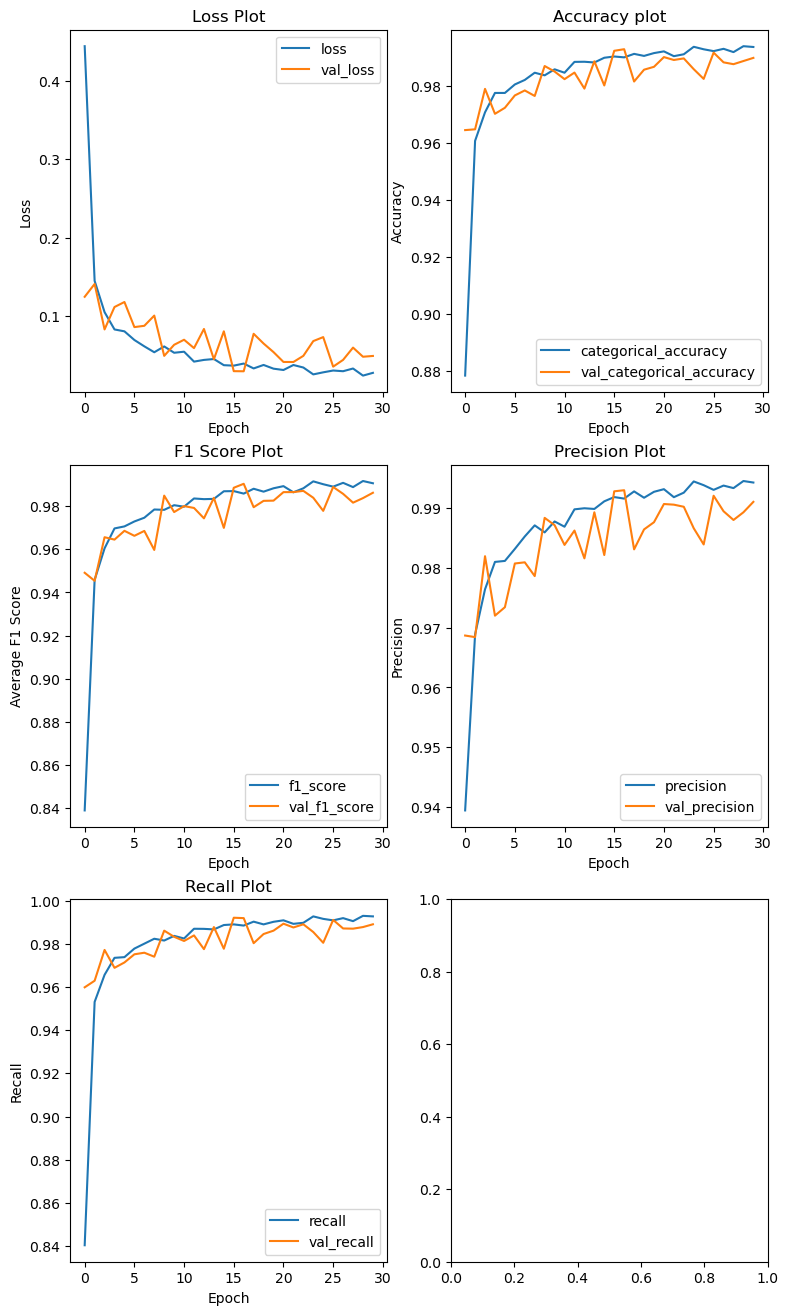

In [26]:
fig, ax = plt.subplots(figsize=(9,16), nrows=3,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
history_df[['f1_score','val_f1_score']].plot(ax=ax[1,0],xlabel='Epoch',ylabel='Average F1 Score',title='F1 Score Plot')
history_df[['precision','val_precision']].plot(ax=ax[1,1],xlabel='Epoch',ylabel='Precision',title='Precision Plot')
history_df[['recall','val_recall']].plot(ax=ax[2,0],xlabel='Epoch',ylabel='Recall',title='Recall Plot')
plt.show()

In [27]:
best_model = load_model('best_model.h5')

In [28]:
val_loss,val_acc, val_f1, val_precision, val_recall = best_model.evaluate(valid_generator)

170/170 [==============================] - 61s 347ms/step - loss: 0.0291 - categorical_accuracy: 0.9928 - f1_score: 0.9904 - precision: 0.9930 - recall: 0.9919
